In [39]:
import time
from utils.data_compression import decompress_data_blosc

import time
import sys

data_store = {}
import matplotlib.pyplot as plt
import numpy as np

def get_total_size(obj, seen=None):
    """Recursively calculates the size of objects in bytes, including nested objects."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
        
    obj_id = id(obj)
    if obj_id in seen:
        return 0

    # Mark this object as seen
    seen.add(obj_id)

    if isinstance(obj, dict):
        size += sum([get_total_size(v, seen) for v in obj.values()])
        size += sum([get_total_size(k, seen) for k in obj.keys()])
    elif isinstance(obj, list) or isinstance(obj, tuple) or isinstance(obj, set):
        size += sum([get_total_size(i, seen) for i in obj])
    
    return size

def get_total_size_in_mb(obj):
    """Returns the total size of an object in megabytes."""
    size_in_bytes = get_total_size(obj)
    size_in_mb = size_in_bytes / (1024 * 1024)  # Convert bytes to MB
    return size_in_mb

def display_capabilities_table(mpClient, capability_type="measure", max_width=75):
    """
    Retrieves and displays capabilities in a table format, wrapping long fields line-by-line.
    
    Parameters:
    - mpClient: Client instance to retrieve capabilities.
    - capability_type: Type of capability to filter by (default is "measure").
    - max_width: Maximum width per line for text fields to wrap.
    """
    capabilities = mpClient.get_capabilities(capability_type=capability_type)

    if capabilities:
        # Print table headers
        print(f"{'ID':<5} {'Endpoint':<30} {'Parameters Schema':<80} {'Result Schema':<80}")
        print("-" * 210)

        # Helper function to wrap text
        def wrap_text(text, width):
            return [text[i:i + width] for i in range(0, len(text), width)]
        
        # Print each capability row
        for c_id, cap in capabilities.items():
            # Get values and wrap long text fields
            endpoint_lines = wrap_text(str(cap.get('endpoint', 'N/A')), max_width)
            parameters_schema_lines = wrap_text(str(cap.get('parameters_schema', 'N/A')), max_width)
            results_schema_lines = wrap_text(str(cap.get('resultSchema', 'N/A')), max_width)
            
            # Find maximum number of lines among the fields to align the row height
            max_lines = max(len(endpoint_lines), len(parameters_schema_lines), len(results_schema_lines))
            
            # Print each line of the wrapped text fields
            for i in range(max_lines):
                c_id_display = str(c_id) if i == 0 else ""  # Display ID only in the first line
                endpoint_display = endpoint_lines[i] if i < len(endpoint_lines) else ""
                parameters_display = parameters_schema_lines[i] if i < len(parameters_schema_lines) else ""
                results_display = results_schema_lines[i] if i < len(results_schema_lines) else ""
                
                # Print each row with formatted spacing
                print(f"{c_id_display:<5} {endpoint_display:<30} {parameters_display:<80} {results_display:<80}")
            
            # Add a separator line after each entry for readability
            print("-" * 110)
    else:
        print("No available capabilities")


        
def on_result_callback(result):
    d_result = decompress_data_blosc(result[0])
    result_size =  get_total_size_in_mb(result[0])
    print(f"++++++++Total size of result: {result_size:.2f} MB")
    print("data is:" , d_result)
    for ch in d_result:
        if ch not in data_store:
            data_store[ch] = {}
        print("received for channel: ",ch)
        for wr_time in d_result[ch]:
            data_store[ch][wr_time] = d_result[ch][wr_time]
            print("WR_Time: ",wr_time)
            print("timetags number: ", len(d_result[ch][wr_time]))
    pass


In [3]:
from MP_client import MeasurementPlaneClient
from utils.data_compression import decompress_data_blosc
data_store = {}
def on_result_callback(result):
    d_result = decompress_data_blosc(result[0])
    print("++++++++++++++data is:" , d_result)
    for ch in d_result:
        if ch not in data_store:
            data_store[ch] = {}
        print("received for channel: ",ch)
        for wr_time in d_result[ch]:
            data_store[ch][wr_time] = d_result[ch][wr_time]
            print("WR_Time: ",wr_time)
            print("timetags number: ", len(d_result[ch][wr_time]))
    pass

BROKER_URL = "http://localhost:5672/"

mpClient = MeasurementPlaneClient(BROKER_URL)

In [40]:
# Example usage:
display_capabilities_table(mpClient)

ID    Endpoint                       Parameters Schema                                                                Result Schema                                                                   
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0     /multiverse/qnet/tt/Alice      {'type': 'object', 'properties': {'channels': {'type': 'string', 'descripti      {'type': 'object', 'patternProperties': {'^[0-9]+$': {'type': 'object', 'pr     
                                     on': "String of channel numbers separated by '|' to measure timetags from"}      operties': {'WR_time': {'type': 'array', 'items': {'type': 'string'}}}, 're     
                                     }}                                                                               quired': ['WR_time']}}}                                                   

In [14]:

# Step 1: Get the capabilities published by agents
capabilities = mpClient.get_capabilities(capability_type="measure")
if len(capabilities):
    print("Available capabilities:")
    for c_id, cap in capabilities.items():
        print(f"{c_id}:{cap['endpoint'],cap['label']}")
else:
    print("No available capabilities")


Available capabilities:
0:('/multiverse/qnet/tt/Alice', 'time tags measurement capability')
1:('/multiverse/qnet/tt/Alice', 'count rate measurement capability')


In [6]:
# Step 2: Chose the desired capability by it's id
capability_id = 0
capability = capabilities[capability_id]

In [7]:
# Step 3: Instantiate a specification of a measurement from the capability
measurement = mpClient.create_measurement(capability)
print(f"Created Measurement: {measurement.specification_message}")

# Step 4: Configure the measurement with parameters
channels =  '2|3'
schedule = "now | 2024-11-21 22:01:00 |stream"
parameters = {
    "channels": channels
}
measurement.configure(
    schedule=schedule,
    parameters=parameters,
    result_callback=on_result_callback,  # Callback function for new results
)
print(f"Configured Measurement Specification: {measurement.specification_message}")

# Step 5: Send the Measurement
mpClient.send_measurement(measurement)

Created Measurement: {'label': 'time tags measurement capability', 'endpoint': '/multiverse/qnet/tt/Alice', 'capabilityName': 'Time_tags_measurement_capability', 'parameters_schema': {'type': 'object', 'properties': {'channels': {'type': 'string', 'description': "String of channel numbers separated by '|' to measure timetags from"}}}, 'resultSchema': {'type': 'object', 'patternProperties': {'^[0-9]+$': {'type': 'object', 'properties': {'WR_time': {'type': 'array', 'items': {'type': 'string'}}}, 'required': ['WR_time']}}}, 'timestamp': '2024-11-07 10:14:20.49', 'nonce': '12345', 'metadata': None, 'specification': 'measure'}
Configured Measurement Specification: {'label': 'time tags measurement capability', 'endpoint': '/multiverse/qnet/tt/Alice', 'capabilityName': 'Time_tags_measurement_capability', 'parameters_schema': {'type': 'object', 'properties': {'channels': {'type': 'string', 'description': "String of channel numbers separated by '|' to measure timetags from"}}}, 'resultSchema':

++++++++++++++data is: {2: {164510.0: array([4.39750738e+02, 1.18551897e+03, 1.93126036e+03, ...,
       7.45710550e+08, 7.45711296e+08, 7.45712041e+08])}, 3: {164510.0: array([4.38309362e+02, 1.18407089e+03, 1.92979587e+03, ...,
       7.45710549e+08, 7.45711294e+08, 7.45712040e+08])}}
received for channel:  2
WR_Time:  164510.0
timetags number:  999987
received for channel:  3
WR_Time:  164510.0
timetags number:  999987
++++++++++++++data is: {2: {164511.0: array([8.24545679e+05, 1.82459686e+06, 2.82448205e+06, ...,
       9.99997053e+11, 9.99998053e+11, 9.99999053e+11])}, 3: {164511.0: array([8.22536799e+05, 1.82258898e+06, 2.82258716e+06, ...,
       9.99997051e+11, 9.99998051e+11, 9.99999051e+11])}}
received for channel:  2
WR_Time:  164511.0
timetags number:  999986
received for channel:  3
WR_Time:  164511.0
timetags number:  999986
++++++++++++++data is: {2: {164512.0: array([5.35417973e+04, 1.05386996e+06, 2.05393214e+06, ...,
       9.99997288e+11, 9.99998288e+11, 9.99999288e

In [8]:
# Step 6: Interrupt the measurement
mpClient.interrupt_measurement(measurement)
print(f"Measurement Interrupted")

Measurement Interrupted


In [9]:
data_store


{2: {164510.0: array([4.39750738e+02, 1.18551897e+03, 1.93126036e+03, ...,
         7.45710550e+08, 7.45711296e+08, 7.45712041e+08]),
  164511.0: array([8.24545679e+05, 1.82459686e+06, 2.82448205e+06, ...,
         9.99997053e+11, 9.99998053e+11, 9.99999053e+11]),
  164512.0: array([5.35417973e+04, 1.05386996e+06, 2.05393214e+06, ...,
         9.99997288e+11, 9.99998288e+11, 9.99999288e+11]),
  164513.0: array([2.88318754e+05, 1.28845793e+06, 2.28866710e+06, ...,
         9.99997520e+11, 9.99998520e+11, 9.99999520e+11]),
  164514.0: array([5.20048893e+05, 1.51992208e+06, 2.51983227e+06, ...,
         9.99997757e+11, 9.99998757e+11, 9.99999757e+11]),
  164515.0: array([7.58119653e+05, 1.75805484e+06, 2.75800203e+06, ...,
         9.99997986e+11, 9.99998986e+11, 9.99999986e+11]),
  164516.0: array([9.86462994e+05, 1.98643818e+06, 2.98669935e+06, ...,
         9.99997228e+11, 9.99998228e+11, 9.99999227e+11]),
  164517.0: array([2.27426396e+05, 1.22746158e+06, 2.22755276e+06, ...,
        

In [10]:
data_store[2]


{164510.0: array([4.39750738e+02, 1.18551897e+03, 1.93126036e+03, ...,
        7.45710550e+08, 7.45711296e+08, 7.45712041e+08]),
 164511.0: array([8.24545679e+05, 1.82459686e+06, 2.82448205e+06, ...,
        9.99997053e+11, 9.99998053e+11, 9.99999053e+11]),
 164512.0: array([5.35417973e+04, 1.05386996e+06, 2.05393214e+06, ...,
        9.99997288e+11, 9.99998288e+11, 9.99999288e+11]),
 164513.0: array([2.88318754e+05, 1.28845793e+06, 2.28866710e+06, ...,
        9.99997520e+11, 9.99998520e+11, 9.99999520e+11]),
 164514.0: array([5.20048893e+05, 1.51992208e+06, 2.51983227e+06, ...,
        9.99997757e+11, 9.99998757e+11, 9.99999757e+11]),
 164515.0: array([7.58119653e+05, 1.75805484e+06, 2.75800203e+06, ...,
        9.99997986e+11, 9.99998986e+11, 9.99999986e+11]),
 164516.0: array([9.86462994e+05, 1.98643818e+06, 2.98669935e+06, ...,
        9.99997228e+11, 9.99998228e+11, 9.99999227e+11]),
 164517.0: array([2.27426396e+05, 1.22746158e+06, 2.22755276e+06, ...,
        9.99997459e+11, 9.

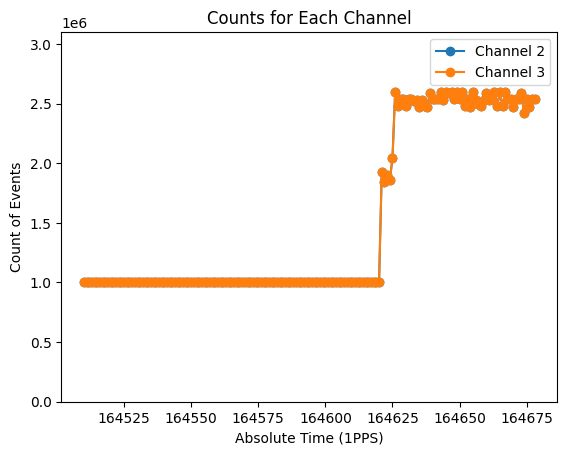

In [12]:
def plot_counts(data_store):
    plt.figure()
    plt.xlabel("Absolute Time (1PPS)")
    plt.ylabel("Count of Events")
    plt.title("Counts for Each Channel")
    plt.ylim(0, 3.1e6)
    # Iterate through each channel and add a bar plot for its counts
    for channel, time_data in data_store.items():
        counts = []
        abs_times = sorted(time_data.keys())
        # Calculate counts for each absolute time
        for abs_time in abs_times:
            counts.append(len(time_data[abs_time]))
        # Plot counts for the channel on the same figure with a label
        plt.plot(abs_times, counts, marker='o', linestyle='-',label=f"Channel {channel}")
    
    # Show legend to differentiate channels
    plt.legend()
    plt.show()

plot_counts(data_store)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

def estimate_delay(timestamps_1, timestamps_2):
    """Estimate the delay between two timestamp arrays."""
    return np.median(timestamps_2 - timestamps_1)

def calculate_delays(data_store, channel1, channel2):
    """
    Calculate delays for each common absolute time between two channels.
    
    Parameters:
    - data_store: Dictionary containing channel data.
    - channel1, channel2: The channels for which to calculate delays.
    
    Returns:
    - delays: Dictionary where keys are abs_time values and values are estimated delays.
    """
    delays = {}
    
    # Ensure both channels have data for the same absolute times
    common_times = set(data_store[channel1].keys()).intersection(data_store[channel2].keys())
    
    for abs_time in sorted(common_times):
        # Get the timestamps for both channels
        timestamps_1 = data_store[channel1][abs_time]
        timestamps_2 = data_store[channel2][abs_time]
        
        # Estimate the delay between the two sets of timestamps
        delay = estimate_delay(timestamps_1, timestamps_2)
        delays[abs_time] = delay
        print(f"Estimated delay for abs_time {abs_time}: {delay}")

    return delays

delays = calculate_delays(data_store, channel1=2, channel2=3)

Estimated delay for abs_time 160777.0: -36.30691719055176
Estimated delay for abs_time 160778.0: -1995.8804931640625
Estimated delay for abs_time 160779.0: -1996.88037109375
Estimated delay for abs_time 160780.0: -1996.8804016113281
Estimated delay for abs_time 160781.0: -1998.8802795410156
Estimated delay for abs_time 160782.0: -1999.8802185058594
Estimated delay for abs_time 160783.0: -1999.8802185058594
Estimated delay for abs_time 160784.0: -1997.88037109375
Estimated delay for abs_time 160785.0: -1998.8802490234375
Estimated delay for abs_time 160786.0: -1998.8802490234375
Estimated delay for abs_time 160787.0: -1998.8802795410156
Estimated delay for abs_time 160788.0: -1999.8802185058594
Estimated delay for abs_time 160789.0: -1997.88037109375
Estimated delay for abs_time 160790.0: -1997.8802490234375
Estimated delay for abs_time 160791.0: -1996.8804016113281
Estimated delay for abs_time 160792.0: -1995.88037109375
Estimated delay for abs_time 160793.0: -1994.8805236816406
Estima